# O Problema das Oito Rainhas

Esse notebook demonstra o `GASolver` usando-o para resolver o Problema das Oito Rainhas.
O problema consiste em colocoar oito rainhas num tabuleiro de xadrez de forma que
nenhuma delas possa atacar a outra.

Para resolver um problema utilizando algoritmos genéticos e, por consequência o `GASolver`,
algumas questões precisam ser definidas:

    1. Como representar uma possível solução, normalmente chamado de 'indivíduo'?
    2. Como realizar uma *mutação* em um indivíduo?
    3. Como realizar o *cruzamento* de dois indivíduos?
    4. Como determinar o quão "perto" da solução um indivíduo está,
       normalmente chamado de "_fitness_"?
    5. Como definir o valor de "_fitness_" máximo e indica que o problema é
       resolvido por um indivíduo?

## Expressando um Indivíduo

No caso do Problema das Oito Rainhas, podemos lançar mão de certas características
das regras e do jogo de xadrez:

    1. O tabuleiro é 8x8
    2. Rainhas atacam toda a sua coluna
    3. Rainhas atacam toda a sua linha
    
Dessas observações, podemos concluir com segurança que uma solução não terá
duas ou mais rainhas na mesma linha nem na mesma coluna. Seja lá como for
a solução, as rainhas não podem compartilhar esses atributos.

Sendo assim, podemos representar um indivíduo - e por consequência uma
possível solução - como sendo simplesmente uma lista de 8 números
inteiros de 1 à 8. Cada posição na lista representa uma coluna
e o número na posição indica a linha na qual existe uma rainha.

Por exemplo, em `[3, 2, 5]`, temos 3 rainhas:

    1. Na coluna 1, linha 3
    2. Na coluna 2, linha 2
    3. Na coluna 3, linha 5
    
Note que no problema real, teremos sempre 8 números.

## Realizando uma Mutação

Existem diversas formas que poderíamos recombinar uma lista de 8 números
para fabricar uma outra lista de 8 números. No caso, vou optar por
uma solução que procede assim:

    1. Um índice entre [1, 6) é escolhido
    2. Tudo o que tiver na lista depois desse índice é invertido
    
```
[1, 2, 3, 4 | 5, 6, 7, 8] -> [1, 2, 3, 4, 8, 7, 5, 6]
            ^
            |
          mutação
```

Por que entre 1 e 6? Isso é uma escolha arbitrária! Fiz nessa faixa porque
gostaria que sempre _alguma coisa_ fosse mutada mas que também _alguma coisa_
ficasse igual. Se fosse possível sortear 0, seria também possível mudar tudo.
Por outro lado se fosse possível sortear 6 ou mais, muito pouco da solução
original iria sobrar. Escolhi esses valores para tentar equilibrar.

In [1]:
from random import randint
def board_mutation(board):
    """
    Pick a random position in the middle of board and flips it
    [1, 2, 3, 4 | 5, 6, 7, 8] -> [1, 2, 3, 4, 8, 7, 5, 6]
                ^
         mutation point
    """
    board = list(board)
    point = randint(1, 6)
    board[point:] = board[point:][::-1]
    return tuple(board)

## Cruzando Indivíduos

Da mesma forma que podemos definir uma mutação de muitas formas diferentes,
também podemos inventar diversas maneiras de criar um novo indivíduo com
base em outros dois que já existem. Decidi proceder de uma maneira
parecida com a mutação:

    1. Um índice aleatório é escolhido entre 1 <= x < 6
    2. Até esse índice, o filho será igual ao ancestral A
    3. Desse índice em diante, o filho será igual ao ancestral B

Assim como na mutação, poderíamos ter feito de diversas formas diferentes,
essa foi uma escolha arbitrária pensando em como fazer com que os dois
ancestrais contribuam para o descendente

In [2]:
def crossover(board_a, board_b):
    """
    Picks a random point in the board. The sibling will be equal to board_a
    up until that point and board_b to the rest.
    """
    # Trimming the ends so that each parent will have a part
    point = randint(1, 6)
    result = board_a[:point]
    result.extend(board_b[point:])
    
    return tuple(result)

In [3]:
crossover([1,2,3,4,5,6,7,8], [4,5,6,1,2,3,7,8])

(1, 5, 6, 1, 2, 3, 7, 8)

## Determinando o _fitness_ e o Valor Ótimo

No caso do Problema das Oito Rainhas, podemos definir o quão boa uma
solução é com base no _número de pares de rainhas que não conseguem
se atacar_. Como queremos que _nenhuma_ rainha consiga se atacar,
o valor ótimo é igual à 28, o número de combinações dois-por-dois
que conseguimos fazer com 8 elementos sem repetição.

Determinar se duas rainhas se atacam envolve determinar 3 itens,
se as rainhas estão na mesma:

    1. Linha
    2. Coluna
    3. Diagonal
    
Determinar as duas primeiras condições é fácil, a terceira
é um pouco mais elaborada. Para dividir responsabilidades
e garantir que cada pedaço de código seja bem contido,
primeiro vou definir uma função que determinar quais
são as posições no tabuleiro nas diagonais de uma
determinada posição:

In [4]:
from functools import lru_cache


@lru_cache(maxsize=64)
def diagonals(line, column):
    """
    Returns a list containing the positions in the
    diagonals of a given square
    
    >>> attacking_positions(8, 1)
    [(7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (1, 8)]
    """
    result = []

    def check_bounds(line, column):
        """
        Checks if a given position is valid. That is, is within the board boundaries
        """
        return (0 < line < 9) and (0 < column < 9)

    def diagonal(line, column, n=1):
        """
        Calculates the diagonals of a given position
        """
        for x in range(1, 9):
            if n == 1:
                line_ = line + x
                column_ = column + x
            elif n == 2:
                line_ = line - x
                column_ = column + x
            elif n == 3:
                line_ = line - x
                column_ = column - x
            elif n == 4:
                line_ = line + x
                column_ = column - x

            if check_bounds(line_, column_):
                yield (line_, column_)

    diagonal1 = list(diagonal(line, column))
    diagonal2 = list(diagonal(line, column, n=2))
    diagonal3 = list(diagonal(line, column, n=3))
    diagonal4 = list(diagonal(line, column, n=4))

    result.extend(diagonal1)
    result.extend(diagonal2)
    result.extend(diagonal3)
    result.extend(diagonal4)
    return result

In [5]:
diagonals(8, 1)

[(7, 2), (6, 3), (5, 4), (4, 5), (3, 6), (2, 7), (1, 8)]

Definida a função que computa as diagonais, podemos escrever uma função `attacks`,
que dada duas rainhas retorna `True` ou `False` se elas podem se atacar ou não.

In [6]:
def attacks(queen_a, queen_b):
    """
    Returns true if those queens are in reachable positions from each other
    
    Args:
        queen_a, queen_b (tuple): a (line, column) tuple representing their positions
        
    >>> attacks((8,1), (6,3))
    True
    >>> attacks((6,3), (8, 1))
    True
    
    """

    return (
        queen_a[0] == queen_b[0]
        or queen_a[1] == queen_b[1]
        or queen_a in diagonals(*queen_b)
    )

In [7]:
attacks((8, 1), (6, 3))

True

Finalmente, podemos definir uma função que dado um tabuleiro,
retorna o número de pares de rainhas que podem se atacar

In [8]:
from itertools import combinations

def count_non_attacking_queens(board):
    """
    Given an integer list of 8 items, each position representing a column on a chess board
    and each number representing a line in that column where there's a queen, returns
    the number of non attacking queens
    """
    queens = [(line, column + 1) for column, line in enumerate(board)]
    queen_combos = combinations(queens, 2)
    
    non_attacking = 0
    
    for queen_a, queen_b in queen_combos:
        non_attacking += 1 if not attacks(queen_a, queen_b) else 0
    return non_attacking

In [9]:
count_non_attacking_queens([8,6,4,2,7,5,3,1])

27

## Usando o `GASolver`

Com todas essas informações definidas, podemos usar o `GASolver` para resolver o problema das Oito Rainhas.
Vou definir a população inicial como sendo 100 tabuleiros aleatórios

In [87]:
from random import sample
initial_pop = [tuple(sample(range(1,9), k=8)) for _ in range(100)]

In [88]:
from ga_solver import GASolver
from ga_solver.pop_selectors import roullete

Com essa população, podemos instanciar um `GASolver` usando o algoritmo de Roleta para seleção.

In [89]:
eight_queen_solver = GASolver(
    initial_pop,
    goal=count_non_attacking_queens,
    target_value=28,
    mutation=board_mutation,
    prob_mutation=0.4,
    crossover_=crossover,
    selector=roullete,
    max_steps=2000,
)

In [90]:
fits = []
while not eight_queen_solver.solution_found:
    print(f"State #{eight_queen_solver.steps}, best fit is {eight_queen_solver.best_fit[1]}")
    fits.append(eight_queen_solver.best_fit[1])
    next(eight_queen_solver)

State #0, best fit is 27
State #1, best fit is 26
State #2, best fit is 26
State #3, best fit is 26
State #4, best fit is 25
State #5, best fit is 24
State #6, best fit is 24
State #7, best fit is 23
State #8, best fit is 24
State #9, best fit is 26
State #10, best fit is 26
State #11, best fit is 26
State #12, best fit is 24
State #13, best fit is 24
State #14, best fit is 24
State #15, best fit is 24
State #16, best fit is 24
State #17, best fit is 20
State #18, best fit is 20
State #19, best fit is 20
State #20, best fit is 20
State #21, best fit is 24
State #22, best fit is 24
State #23, best fit is 25
State #24, best fit is 22
State #25, best fit is 22
State #26, best fit is 22
State #27, best fit is 22
State #28, best fit is 25
State #29, best fit is 25
State #30, best fit is 26
State #31, best fit is 23
State #32, best fit is 23
State #33, best fit is 23
State #34, best fit is 26
State #35, best fit is 26
State #36, best fit is 25
State #37, best fit is 25
State #38, best fit is

In [91]:
eight_queen_solver.solution_found

True

In [92]:
import matplotlib.pyplot as plt

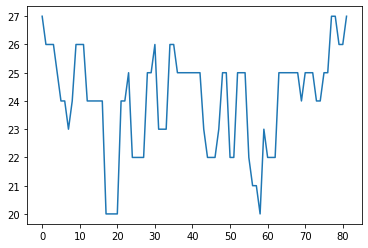

In [93]:
plt.plot(fits)